<a href="https://colab.research.google.com/github/pthread/code/blob/main/02_Tile_Tensor_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tile tensors


## Introduction
This notebook introduces the basics of using packing agnostic programming with [HELayers](https://hub.docker.com/r/ibmcom/helayers-pylab). Specifically, how to include the [pyhelayers](https://hub.docker.com/r/ibmcom/helayers-pylab) library, initialize an encryption context and perform some simple encryption and decryption operations.
HELayers and the concept of tile tensors rely on the paper

> Ehud Aharoni, Allon Adir, Moran Baruch, Nir Drucker, Gilad Ezov, Ariel Farkash, Lev Greenberg, Ramy Masalha, Guy Moshkowich, Dov Murik, Hayim Shaul, and Omri Soceanu. 2020. HeLayers: A Tile Tensors Framework for Large Neural Networks on Encrypted Data. PoPETs 2023.

<details>

<summary>Press for other literature on HELayers and tile tensors</summary>

#### Packing

* Ehud Aharoni, Moran Baruch, Nir Drucker, Gilad Ezov, Eyal Kushnir, Guy Moshkowich, and Omri Soceanu. 2022. Poster: Secure SqueezeNet inference in 4 minutes. 43rd IEEE Symposium on Security and Privacy (2022). [Read more](https://arxiv.org/abs/2011.01805)
* Ehud Aharoni, Nir Drucker, Gilad Ezov, Hayim Shaul, and Omri Soceanu. 2022. Complex Encoded Tile Tensors: Accelerating Encrypted Analytics. IEEE Security & Privacy 01, 2–10.
[Read more](https://doi.org/10.1109/MSEC.2022.3181689)

#### HELayers

* John Buselli. 2021. Secure AI workloads using fully homomorphic encrypted data. (Sep 2021). [Read more](https://developer.ibm.com/blogs/secure-ai-workloads-using-fully-homomorphic-encrypted-data/)
* IBM. 2021. Fully Homomorphic Encryption (FHE) - Never decrypt your data, even during computation. [Read more](https://fhe-website.mybluemix.net/?_ga=2.94032030.24152571.1666765225-1379575878.1644260568)

</details>

<br/>This tutorial assumes you are already familiar with the concept of homomorphic encryption (HE), with the CKKS scheme and the operations it supports.

<details>

<summary>If not, press the button for relevant references</summary>

* Cheon, J. H., Kim, A., Kim, M., and Song, Y. (2017). Homomorphic Encryption for Arithmetic of Approximate Numbers. In T. Takagi and T. Peyrin (Eds.), Advances in Cryptology -- ASIACRYPT 2017 (Vol. 1, pp. 409–437). Springer International Publishing. [Read more](https://doi.org/10.1007/978-3-319-70694-8_15)

* Cheon, J. H., Han, K., Kim, A., Kim, M., and Song, Y. (2019). A Full RNS Variant of Approximate Homomorphic Encryption. In C. Cid and M. J. Jacobson Jr. (Eds.), Selected Areas in Cryptography -- SAC 2018 (pp. 347–368). Springer International Publishing. [Read more](https://doi.org/10.1007/978-3-030-10970-7_16)
    
</details>


<br>  

We start by importing the required packages for this tutorial

In [ ]:
import numpy as np
import math as math
from timeit import default_timer
from matplotlib import pyplot as plt


## Step 1. Importing and initializing

Pyhelayers library is the Python API for HELayers, which we first need to import.

For demo purposes, we turn on pretty printing of tiles.

In [ ]:
!pip install pyhelayers
import pyhelayers

print("Imported pyhelayers", pyhelayers.VERSION)

pyhelayers.get_print_options().tt_demo_tiles = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 MB 13.4 MB/s eta 0:00:00
Imported pyhelayers 1.5.3.0


To use pyhelayers we first need to initialize `HeContext` and a `TTEncoder` object.  
(NOTE: to get help on pyhelayers or any of its classes type `help(pyhelayers)` or `help(pyhelayers.HeContext)`, etc...)

An HeContext is the main object for accessing the underlying FHE encryption scheme. Once initialized, it generates the keys and all the other data structures required for working with FHE. It is an abstract class with several different concrete implementations, each for a different FHE scheme, or a different open source library implementing these schemes.

In this notebook, we will use the `MockupContext`, which is a non-encrypted implementation for quick tests. However, HELayer's APIs abstract away the underlying details, so the same code can later be switched to work with a real FHE scheme by simply changing the HeContext creation.

An `HeContext` is initialized with an `HeConfigRequirement` object that defines our requirements from the FHE scheme: e.g., the number of slots in a ciphertext, the maximal multiplication depth of the evaluated circuit, or the security level. For demonstration purposes, we use ciphertexts with only 8 slots. To this end, we create a configuration using the `insecure` method, which explicitly states that the security level is 0. This allows us to use the Mockup implementation.

See the FHE basics demo in [pylab](https://ibm.github.io/helayers/pylab/) for more details.

Finally, a `TTEncoder` object is responsible for encrypting and decrypting tensors. How it works is the central focus of these demos. Note that in FHE there's also an encoding step which is a preprocessing step before encryption, and similarly a postprocessing decoding step after decryption. Hence, the encryption and decryption methods are called `encode_encrypt` and `decrypt_decode`. In some advanced scenarios, it is useful to perform these steps separately.

In [ ]:
# Initialize a mockup context with 8 slots.
requirement = pyhelayers.HeConfigRequirement.insecure(
    num_slots = 8,                  # Number of slots per ciphertext
    multiplication_depth = 2,       # Allow 2 levels of multiplications
    fractional_part_precision = 40, # Set the precision to 1/2^40.
    integer_part_precision = 20    # Set the largest number to 2^20.
    )

# Use a mockup HE context and initialize it with the requirements object above.
he_context = pyhelayers.MockupContext()
he_context.init(requirement)

# Create the Encoder using the context.
encoder = pyhelayers.TTEncoder(he_context)

print("Initialized a context with ", he_context.slot_count(), " slots and an encoder object")


Initialized a context with  8  slots and an encoder object


A $5 \times 6$ matrix $M$ will serve as the plaintext for the demonstrations.



In [ ]:
def genDemoMatrix(m, n):
    """ Return an m x n matrix with values [0 ,..., m x n - 1].
    """
    return np.arange(0, m*n).reshape((m, n))

# Prepare a 5x6 matrix with values [0,...,29].
M = genDemoMatrix(5,6)
print("Plaintext matrix M=\n", M)

Plaintext matrix M=
 [[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]]


<br>

## Step 2. Different packings for the same matrix

Different packings affect the performance characteristic of every HE solution.
We now show how the same marix can be packed in different ways:
<ul>
    <li> Packing each row of $M$ in a ciphertext</li>
    <li> Packing each column of $M$ in a ciphertext</li>
    <li> Using a more flexible packing</li>
</ul>

### Step 2.1. Packing each row of M in a ciphertext
We pack $M$ using tiles (ciphertexts) of shape $1 \times 8$. This effectively places a single row in every ciphertext.
Since we have 8 slots and each row has only 6 elements we end up with 8 - 6 = 2 unused slots in each ciphertext.

To perform the packing we use the [TTShape object](https//add.a.link). This objects keeps a shape.
Subsequently, we ask the encoder to encode and encrypt a tile tensor of M with the shape that we have just defined.

When printing the resulting ciphertext $C$, we see the tile tensor shape $\left[5, \frac{6}{8}\right]$ the chain index (CI), and the arrangement of the data inside 5 different tiles, i.e, the external tensor shape is $5 \times 1$.

In [ ]:
shape = pyhelayers.TTShape([1, 8])
C = encoder.encode_encrypt(shape, M)

print(C)

CTileTensor [5, 6/8] CI=2 tiles=5 memory=-0.000 GB

Tile tensor logical content:
Tensor[5,6]
    0    1    2    3    4    5
    6    7    8    9   10   11
   12   13   14   15   16   17
   18   19   20   21   22   23
   24   25   26   27   28   29

Tile array:
Tile[0,0]                                 
+----------------------------------------+
|    0    1    2    3    4    5    0    0|
+----------------------------------------+

Tile[1,0]                                 
+----------------------------------------+
|    6    7    8    9   10   11    0    0|
+----------------------------------------+

Tile[2,0]                                 
+----------------------------------------+
|   12   13   14   15   16   17    0    0|
+----------------------------------------+

Tile[3,0]                                 
+----------------------------------------+
|   18   19   20   21   22   23    0    0|
+----------------------------------------+

Tile[4,0]                                 
+---

### Step 2.2. Packing each column of M in a ciphertext
We pack $M$ using tiles (ciphertext) of shape $8 \times 1$.
This effectively places a singe column in every ciphertext.
Since we have 8 slots and each row has only 5 elements we end up with 8-5=3 unused slots in each ciphertext, which we pad with zeros.
Here, the tile tensor shape is $\left[\frac{5}{8}, 6\right]$ and the external tensor shape is $1 \times 6$.

In [ ]:
shape = pyhelayers.TTShape([8, 1])
cvals = encoder.encode_encrypt(shape, M)

print(cvals)

CTileTensor [5/8, 6] CI=2 tiles=6 memory=-0.000 GB

Tile tensor logical content:
Tensor[5,6]
    0    1    2    3    4    5
    6    7    8    9   10   11
   12   13   14   15   16   17
   18   19   20   21   22   23
   24   25   26   27   28   29

Tile array:
Tile[0,0]  Tile[0,1]  Tile[0,2]  Tile[0,3]  Tile[0,4]  Tile[0,5]
+-----+  +-----+  +-----+  +-----+  +-----+  +-----+
|    0|  |    1|  |    2|  |    3|  |    4|  |    5|
|    6|  |    7|  |    8|  |    9|  |   10|  |   11|
|   12|  |   13|  |   14|  |   15|  |   16|  |   17|
|   18|  |   19|  |   20|  |   21|  |   22|  |   23|
|   24|  |   25|  |   26|  |   27|  |   28|  |   29|
|    0|  |    0|  |    0|  |    0|  |    0|  |    0|
|    0|  |    0|  |    0|  |    0|  |    0|  |    0|
|    0|  |    0|  |    0|  |    0|  |    0|  |    0|
+-----+  +-----+  +-----+  +-----+  +-----+  +-----+




### Step 2.3. Packing with $2\times 4$ block in each ciphertext
In this example, we pack $M$ using tiles of shape $2 \times 4$.
This effectively divides the matrix to sub-blocks and places each one in a ciphertext.
Since we have 5 rows which is not divisible by 2, the last row of tiles is padded with a row of zeros.
The tile tensor shape is $\left[\frac{5}{2}, \frac{6}{4}\right]$ and the external tensor shape is $3 \times 2$.

In [ ]:
shape = pyhelayers.TTShape([2, 4])
cvals = encoder.encode_encrypt(shape, M)

print(cvals)

CTileTensor [5/2, 6/4] CI=2 tiles=6 memory=-0.000 GB

Tile tensor logical content:
Tensor[5,6]
    0    1    2    3    4    5
    6    7    8    9   10   11
   12   13   14   15   16   17
   18   19   20   21   22   23
   24   25   26   27   28   29

Tile array:
Tile[0,0]               Tile[0,1]             
+--------------------+  +--------------------+
|    0    1    2    3|  |    4    5    0    0|
|    6    7    8    9|  |   10   11    0    0|
+--------------------+  +--------------------+

Tile[1,0]               Tile[1,1]             
+--------------------+  +--------------------+
|   12   13   14   15|  |   16   17    0    0|
|   18   19   20   21|  |   22   23    0    0|
+--------------------+  +--------------------+

Tile[2,0]               Tile[2,1]             
+--------------------+  +--------------------+
|   24   25   26   27|  |   28   29    0    0|
|    0    0    0    0|  |    0    0    0    0|
+--------------------+  +--------------------+




### Question
What shpe yields the minimal number of tiles when the number of slots in a ciphertext is 16?
<details>
    <summary> Answer </summary>

Tile shape 1x16, Number of tiles = 5, Tile tensor shape = [5, 6/16]<br/>
<b>Tile shape 2x8, Number of tiles = 3, Tile tensor shape = [5/2, 6/8]</b><br/>
Tile shape 4x4, Number of tiles = 4, Tile tensor shape = [5/4, 6/4]<br/>
<b>Tile shape 8x2, Number of tiles = 3, Tile tensor shape = [5/8, 6/2]</b><br/>
Tile shape 16x1, Number of tiles = 6, Tile tensor shape = [5/16, 6]<br/><br/>    
</details>

<br/>
What shape yields the minimal number of tiles when the number of slots in a ciphertext is 32?
<br/>
<details>
    <summary> Answer </summary>
Tile shape 1x32, Number of tiles = 5, Tile tensor shape = [5, 6/32]<br/>
Tile shape 2x16, Number of tiles = 3, Tile tensor shape = [5/2, 6/16]<br/>
<b>Tile shape 4x8, Number of tiles = 2, Tile tensor shape = [5/4, 6/8]</b><br/>
    <b>Tile shape 8x4, Number of tiles = 2, Tile tensor shape = [5/8, 6/4]</b><br/>
Tile shape 16x2, Number of tiles = 3, Tile tensor shape = [5/16, 6/2]<br/>
Tile shape 32x1, Number of tiles = 6, Tile tensor shape = [5/32, 6]    <br/><br/>
</details>

<br/>
Use the code below to test your results.

In [ ]:
# Set s with the required number of slots
s = 16

# Initialize a mockup context with 8 slots.
requirement2 = pyhelayers.HeConfigRequirement.insecure(
    num_slots = s,                  # Number of slots per ciphertext
    multiplication_depth = 2,       # Allow 2 levels of multiplications
    fractional_part_precision = 40, # Set the precision to 1/2^40.
    integer_part_precision = 20    # Set the largest number to 2^20.
    )

# Use a mockup HE context and initialize it with the requirements object above.
he_context2 = pyhelayers.MockupContext()
he_context2.init(requirement2)

# Create the Encoder using the context.
encoder2 = pyhelayers.TTEncoder(he_context2)

for i in range(int(math.log2(s))+1):
    d1 = 2**i
    d2 = int(s/d1)
    shape2 = pyhelayers.TTShape([d1, d2])
    cvals = encoder2.encode_encrypt(shape2, M)
    print(f'Tile shape {d1}x{d2}, \tNumber of tiles = {cvals.get_num_used_tiles()}, \tTile tensor shape = {cvals.get_shape()}')


Tile shape 1x16, 	Number of tiles = 5, 	Tile tensor shape = [5, 6/16]
Tile shape 2x8, 	Number of tiles = 3, 	Tile tensor shape = [5/2, 6/8]
Tile shape 4x4, 	Number of tiles = 4, 	Tile tensor shape = [5/4, 6/4]
Tile shape 8x2, 	Number of tiles = 3, 	Tile tensor shape = [5/8, 6/2]
Tile shape 16x1, 	Number of tiles = 6, 	Tile tensor shape = [5/16, 6]


## Step 3. A method for matrix-matrix multiplication

Given two matrices $A$ and $B$ we would like to compute their product $R=A B$.  When using CKKS, we would like to leverage its single instruction multiple data (SIMD) capabilities. Specifically, we would like to pack the matrices in such a way as to minimize utilize the most number of slots, and minimize the number of operators.

It can be shown that $R= A B$ can be computed as follows. Say the shapes of $A$ and $B$ are $[x,y]$ and $[y,z]$ respectively. We'll reshape them to $[x,y,1]$ and $[1,y,z]$. Using broadcasting rules, it can be shown that $R=\sum^1 (A \odot B)$ where $\odot$ is elementwise multiplication, and $\sum^1$ sums over the second dimension (having index $1$). The result has the shape $[x,1,z]$.

Packing $A$ and $B$ into tile tensors $T_A$ and $T_B$ with shapes $[\frac{x}{t_0},\frac{y}{t_1},\frac{*}{t_2}]$ and $[\frac{*}{t_0},\frac{y}{t_1},\frac{z}{t_2}]$ allows us to repeat the same computation under encryption:
$T_R=\sum^1 (T_A \odot T_B)$. The shape of the tiles $[t_0,t_1,t_2]$ will determine the efficiency of this operation, as we explore next.

In [ ]:
def matMul(x,y,z, t0,t1,t2):
    assert t0*t1*t2 == he_context.slot_count(), "tile must be the same size as number of slots"

    he_context.start_operation_count_track()

    # Generate the input matrix X and weights vector w (in plaintext)
    A = genDemoMatrix(x,y)
    B = genDemoMatrix(y,z)

    # Compute and set the tile tensors dimensions
    shapeA = pyhelayers.TTShape([t0,t1,t2]).get_with_duplicated_dim(2)
    shapeB = pyhelayers.TTShape([t0,t1,t2]).get_with_duplicated_dim(0)

    # Encrypt the input matrix
    TA = encoder.encode_encrypt(shapeA, np.reshape(A,[x,y,1]))
    TB = encoder.encode_encrypt(shapeB, np.reshape(B,[1,y,z]))

    print("Tile tensor for A:\n", TA)
    print("Tile tensor for B:\n",TB)

    TR=TA
    TR.multiply_and_sum(TB,1)
    print("Tile tensor for R=", TR)
    print(he_context.get_stats_and_clear())

    # Verify we got it right
    res1=encoder.decrypt_decode_double(TR)
    res2=np.matmul(A,B)
    # Remove unused dim
    res1=np.squeeze(res1)
    err=np.max(res1-res2)
    print('Maximal error',err)


#### Mat-mul for shapes [4,6] and [6,5] with tile shape [8,1,1]

This option packs the first matrix column by column. The second matrix has each element packed in a separate tile, fully duplicated.

In [ ]:
matMul(4,6,5, 8,1,1)

Tile tensor for A:
 CTileTensor [4/8, 6, 1] CI=2 tiles=6 memory=-0.000 GB

Tile tensor logical content:
Tensor[4,6]
    0    1    2    3    4    5
    6    7    8    9   10   11
   12   13   14   15   16   17
   18   19   20   21   22   23

Tile array:
Tile[0,0,0]
+-----+
|    0|
|    6|
|   12|
|   18|
|    0|
|    0|
|    0|
|    0|
+-----+

Tile[0,1,0]
+-----+
|    1|
|    7|
|   13|
|   19|
|    0|
|    0|
|    0|
|    0|
+-----+

Tile[0,2,0]
+-----+
|    2|
|    8|
|   14|
|   20|
|    0|
|    0|
|    0|
|    0|
+-----+

Tile[0,3,0]
+-----+
|    3|
|    9|
|   15|
|   21|
|    0|
|    0|
|    0|
|    0|
+-----+

Tile[0,4,0]
+-----+
|    4|
|   10|
|   16|
|   22|
|    0|
|    0|
|    0|
|    0|
+-----+

Tile[0,5,0]
+-----+
|    5|
|   11|
|   17|
|   23|
|    0|
|    0|
|    0|
|    0|
+-----+


Tile tensor for B:
 CTileTensor [*/8, 6, 5] CI=2 tiles=30 memory=-0.000 GB

Tile tensor logical content:
Tensor[6,5]
    0    1    2    3    4
    5    6    7    8    9
   10   11   12   1

This method requires many multiplications: 30, but no rotations.

#### Mat-mul for shapes [4,6] and [6,5] with tile shape [4,2,1]

In [ ]:
matMul(4,6,5, 4,2,1)

Tile tensor for A:
 CTileTensor [4/4, 6/2, 1] CI=2 tiles=3 memory=-0.000 GB

Tile tensor logical content:
Tensor[4,6]
    0    1    2    3    4    5
    6    7    8    9   10   11
   12   13   14   15   16   17
   18   19   20   21   22   23

Tile array:
Tile[0,0,0] 
+----------+
|    0    1|
|    6    7|
|   12   13|
|   18   19|
+----------+

Tile[0,1,0] 
+----------+
|    2    3|
|    8    9|
|   14   15|
|   20   21|
+----------+

Tile[0,2,0] 
+----------+
|    4    5|
|   10   11|
|   16   17|
|   22   23|
+----------+


Tile tensor for B:
 CTileTensor [*/4, 6/2, 5] CI=2 tiles=15 memory=-0.000 GB

Tile tensor logical content:
Tensor[6,5]
    0    1    2    3    4
    5    6    7    8    9
   10   11   12   13   14
   15   16   17   18   19
   20   21   22   23   24
   25   26   27   28   29

Tile array:
Tile[0,0,0]   Tile[0,0,1]   Tile[0,0,2]   Tile[0,0,3]   Tile[0,0,4] 
+----------+  +----------+  +----------+  +----------+  +----------+
|    0    5|  |    1    6|  |    2    7|  

This method required much less multiplications: only 15. But it added 5 rotations.
The tiles of the result contain junk values in their second column, as indicated by the 1?/2 notation in their shape.

#### Mat-mul for shapes [4,6] and [6,5] with tile shape [4,1,2]

In [ ]:
matMul(4,6,5, 4,1,2)

Tile tensor for A:
 CTileTensor [4/4, 6, */2] CI=2 tiles=6 memory=-0.000 GB

Tile tensor logical content:
Tensor[4,6]
    0    1    2    3    4    5
    6    7    8    9   10   11
   12   13   14   15   16   17
   18   19   20   21   22   23

Tile array:
Tile[0,0,0] 
+----------+
|    0    0|
|    6    6|
|   12   12|
|   18   18|
+----------+

Tile[0,1,0] 
+----------+
|    1    1|
|    7    7|
|   13   13|
|   19   19|
+----------+

Tile[0,2,0] 
+----------+
|    2    2|
|    8    8|
|   14   14|
|   20   20|
+----------+

Tile[0,3,0] 
+----------+
|    3    3|
|    9    9|
|   15   15|
|   21   21|
+----------+

Tile[0,4,0] 
+----------+
|    4    4|
|   10   10|
|   16   16|
|   22   22|
+----------+

Tile[0,5,0] 
+----------+
|    5    5|
|   11   11|
|   17   17|
|   23   23|
+----------+


Tile tensor for B:
 CTileTensor [*/4, 6, 5/2] CI=2 tiles=18 memory=-0.000 GB

Tile tensor logical content:
Tensor[6,5]
    0    1    2    3    4
    5    6    7    8    9
   10   11   12   13 

The last option resulted with a little more multiplications: 18.
But it performs no rotations, and also the number of relinearizations has dropped from 5 to 3.

## Step 4. Linear regression - secure benchmarks


Let us set up a secure context

In [ ]:


# Initialize a CKKS context with 16,384 slots.
requirement = pyhelayers.HeConfigRequirement(
    num_slots = 8*1024,            # Number of slots per ciphertext
    multiplication_depth = 1,       # Allow 1 levels of multiplications
    fractional_part_precision = 40, # Set the precision to 1/2^40.
    integer_part_precision = 20,    # Set the largest number to 2^20.
    security_level = 128)

# Use an HE context that uses Micorsoft SEAL
he_context = pyhelayers.SealCkksContext()
he_context.init(requirement)
print("Initialized a context with ", he_context.slot_count(), " slots")

# Create the Encoder using the context.
encoder = pyhelayers.TTEncoder(he_context)

Initialized a context with  8192  slots


Here is our function that computes linear regression over a batch of samples. This time we added code for measuring time and memory.

In [ ]:

def print_stats(s):
    print("Latency = ", s[0], " seconds.")
    print("Amortized latency = ", s[1], " seconds per input.")
    print("RAM of tile tensors = ", (s[2]/1024/1024), "MB.")

def plotGraphs(logRange, allLat, allMem):

    mainFig, axLeft = plt.subplots()

    # Plot a graph between alpha and the latency
    axLeft.set_xlabel("log tile 0")
    axLeft.set_ylabel("latency (sec.)")
    axLeft.plot(logRange,allLat,color='blue')

    axRight=axLeft.twinx()
    axRight.set_ylabel("Memory (MB)")
    axRight.plot(logRange,allMem,color='red')
    plt.show()


def linearRegressionStats(numSamples, numFeatures, tileSize0, tileSize1):
    assert tileSize0*tileSize1 == he_context.slot_count(), "tile must be the same size as number of slots"
    #print(f"Tile shape [{tileSize0},{tileSize1}]")
    # Generate the input matrix X and weights vector w (in plaintext)
    X = genDemoMatrix(numSamples,numFeatures)
    w = genDemoMatrix(1,numFeatures)

    # Compute and set the tile tensors dimensions
    shapeX = pyhelayers.TTShape([tileSize0, tileSize1])
    shapeW = pyhelayers.TTShape([tileSize0, tileSize1]).get_with_duplicated_dim(0)

    # Encrypt the input matrix
    cX = encoder.encode_encrypt(shapeX, X)
    cW = encoder.encode_encrypt(shapeW, w)

    estMemW = cW.get_estimated_memory_usage_bytes()
    estMemX = cX.get_estimated_memory_usage_bytes()


    # Compute and print the inference results
    cY = cX
    startTime = default_timer()
    cY.multiply_and_sum(cW,1)
    latency         = default_timer() - startTime
    amortized_latency= latency/numSamples

    estMemY=cY.get_estimated_memory_usage_bytes()

    total_mem=(estMemW+estMemX+estMemY)/1024.0/1024.0

    #print_stats([latency,amortized_latency,total_mem])

    return latency,total_mem




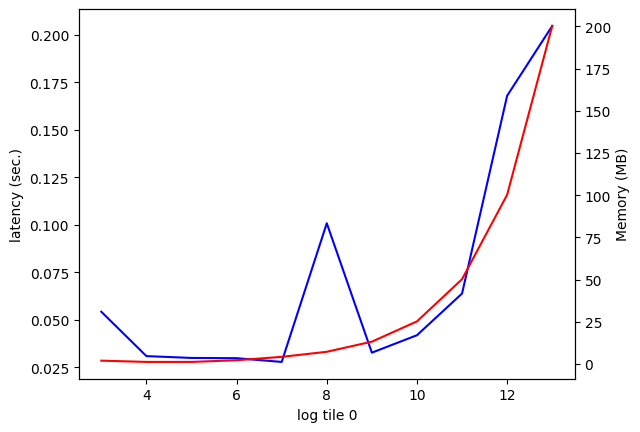

In [ ]:
num_samples=10
num_features=200

allMem=[]
allLat=[]
logRange=range(3,14)
for i in logRange:
  tile_size0=2**i
  tile_size1=8192/tile_size0

  lat,mem=linearRegressionStats(num_samples,num_features, tile_size0, tile_size1)
  allLat.append(lat)
  allMem.append(mem)


plotGraphs(logRange, allLat, allMem)

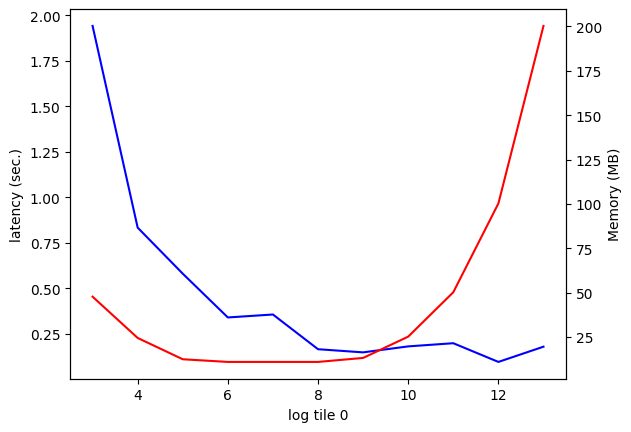

In [ ]:
num_samples=500
num_features=200

allMem=[]
allLat=[]
logRange=range(3,14)
for i in logRange:
  tile_size0=2**i
  tile_size1=8192/tile_size0

  lat,mem=linearRegressionStats(num_samples,num_features, tile_size0, tile_size1)
  allLat.append(lat)
  allMem.append(mem)

plotGraphs(logRange, allLat, allMem)


## Step 5. Up next

In the above examples, we saw how even for a simple operation like linear regression the different packing have high effect on the number of tiles and thus on the number of operations.
In the next notebook we are going to see how different packing options affect the performance of our code.